# Performance Evaluation - Portfolio Managers Analysis

**Problem 3:** You run a large university endowment that invests with outside portfolio managers. Two final candidates have been presented to you. The PMs' track records from 2005 to 2024 are included in the spreadsheet "PM.xlsx." You might also need the data for monthly market excess returns, returns for the SMB and HML factors, and one-month Treasury bill rates from Ken French's website.


## Data Loading and Setup


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

# Load data
manager_df = pd.read_excel('PM.xlsx')
ff3_df = pd.read_csv('F-F_Research_Data_Factors.csv')

# Process dates and merge data
ff3_df['Date'] = pd.to_datetime(ff3_df['Date'], format='%Y%m')
manager_df['Date'] = pd.to_datetime(manager_df['Date'], format='%Y%m')
ff3_df = ff3_df.set_index('Date')
manager_df = manager_df.set_index('Date')

# Convert to decimal format
manager_df /= 100
ff3_df /= 100

# Merge datasets
df = pd.merge(left=manager_df, right=ff3_df, left_index=True, right_index=True)

print(f"Data loaded: {df.shape[0]} observations from {df.index.min().strftime('%Y-%m')} to {df.index.max().strftime('%Y-%m')}")


Data loaded: 240 observations from 2005-01 to 2024-12


## (a) Summarize the performances of the two managers

### Scatter plots of managers' monthly excess returns against market excess returns


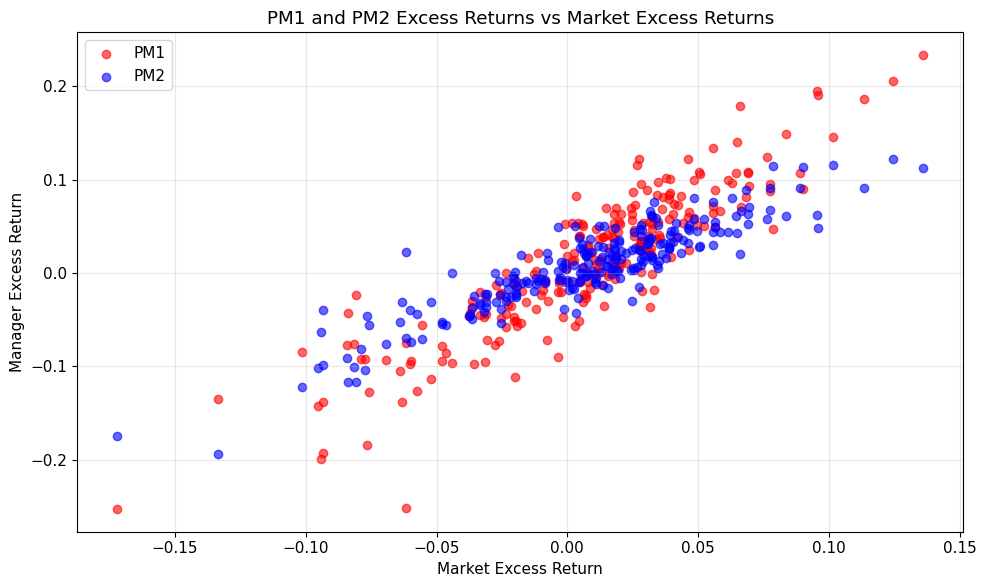

In [23]:
# Calculate excess returns
df['PM1_excess'] = df['PM1'] - df['RF']
df['PM2_excess'] = df['PM2'] - df['RF']

# Create combined scatter plot on one axes
plt.figure(figsize=(10, 6))
plt.scatter(df['Mkt-RF'], df['PM1_excess'], alpha=0.6, color='red', label='PM1')
plt.scatter(df['Mkt-RF'], df['PM2_excess'], alpha=0.6, color='blue', label='PM2')
plt.xlabel('Market Excess Return')
plt.ylabel('Manager Excess Return')
plt.title('PM1 and PM2 Excess Returns vs Market Excess Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Boxplot of the two managers' monthly returns


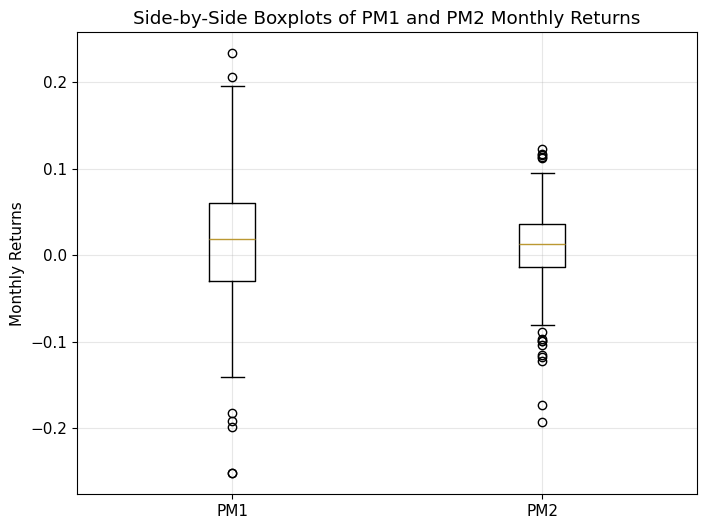

In [24]:
plt.figure(figsize=(8, 6))
plt.boxplot([df['PM1'], df['PM2']], tick_labels=['PM1', 'PM2'])
plt.title('Side-by-Side Boxplots of PM1 and PM2 Monthly Returns')
plt.ylabel('Monthly Returns')
plt.grid(True, alpha=0.3)
plt.show()


### Performance Metrics: Mean, Standard Deviation, Sharpe Ratio, Information Ratio, and Maximum Drawdown


In [25]:
def calculate_performance_metrics(returns, rf_rate, market_excess):
    """Calculate performance metrics for a portfolio manager"""
    excess_returns = returns - rf_rate
    excess_vs_market = returns - market_excess - rf_rate
    
    # Basic statistics
    mean_return = returns.mean()
    std_return = returns.std()
    
    # Sharpe ratio
    sharpe_ratio = excess_returns.mean() / excess_returns.std()
    
    # Information ratio (excess return over market / tracking error)
    info_ratio = excess_vs_market.mean() / excess_vs_market.std()
    
    # Maximum drawdown calculation
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Mean': mean_return,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio,
        'Information Ratio': info_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for both managers
pm1_metrics = calculate_performance_metrics(df['PM1'], df['RF'], df['Mkt-RF'])
pm2_metrics = calculate_performance_metrics(df['PM2'], df['RF'], df['Mkt-RF'])

# Display results
results_df = pd.DataFrame({'PM1': pm1_metrics, 'PM2': pm2_metrics})
print("Performance Metrics Summary:")
print("=" * 40)
print(results_df.round(4))


Performance Metrics Summary:
                      PM1     PM2
Mean               0.0137  0.0087
Std Dev            0.0758  0.0466
Sharpe Ratio       0.1642  0.1584
Information Ratio  0.1070 -0.0338
Max Drawdown      -0.5923 -0.5120


### Observations on Differences and Outliers

**Key Differences between PM1 and PM2:**

1. **Volatility**: PM1 exhibits much higher variance in returns compared to PM2, indicating higher risk.

2. **Return Distribution**: Both managers show similar mean returns, but PM2 has significantly more outliers, particularly in the negative direction.

3. **Risk-Return Profile**: PM1 shows higher volatility but also potentially higher returns, while PM2 appears more conservative with tighter return distribution.

4. **Outlier Treatment**: The presence of outliers, especially for PM2, suggests that winsorization might be considered to remove extreme high and low returns for more robust analysis.


## (b) Evidence for ability to outperform the market using Fama-French 3-factor model

### Fama-French 3-Factor Model: R*ᵢ,ₜ = αᵢ + βᵢRₘ,ₜ + γᵢRₕₘₗ,ₜ + δᵢRₛₘᵦ,ₜ + εᵢ,ₜ

### PM1 Regression Results


In [26]:
# PM1 Fama-French 3-factor regression
Y_pm1 = df['PM1'] - df['RF']  # PM1 excess returns
X_pm1 = sm.add_constant(df[['Mkt-RF', 'HML', 'SMB']])

model_pm1 = sm.OLS(endog=Y_pm1, exog=X_pm1).fit()
print("PM1 Fama-French 3-Factor Model Results:")
print("=" * 50)
model_pm1.summary()


PM1 Fama-French 3-Factor Model Results:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.361e+04
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          4.96e-264
Time:                        12:57:36   Log-Likelihood:                 898.10
No. Observations:                 240   AIC:                            -1788.
Df Residuals:                     236   BIC:                            -1774.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.249      0.213      -0.000       0.001
Mkt-RF         1.4137      0.009    157.805      0.000       1.396       1.431
HML           -0.8074      0.012    -68.223      0.000      -0.831      -0.784
SMB            0.9894      0.016     62.211      0.000       0.958       1.021
==============================================================================
Omnibus:                        5.807   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.486
Skew:                           0.335   Prob(JB):                       0.0644
Kurtosis:                       3.317   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### PM2 Regression Results


In [27]:
# PM2 Fama-French 3-factor regression
Y_pm2 = df['PM2'] - df['RF']  # PM2 excess returns
X_pm2 = sm.add_constant(df[['Mkt-RF', 'HML', 'SMB']])

model_pm2 = sm.OLS(endog=Y_pm2, exog=X_pm2).fit()
print("PM2 Fama-French 3-Factor Model Results:")
print("=" * 50)
model_pm2.summary()


PM2 Fama-French 3-Factor Model Results:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2665.
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          1.16e-181
Time:                        12:57:36   Log-Likelihood:                 821.48
No. Observations:                 240   AIC:                            -1635.
Df Residuals:                     236   BIC:                            -1621.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.135      0.257      -0.000       0.002
Mkt-RF         0.9076      0.012     73.620      0.000       0.883       0.932
HML            0.5677      0.016     34.858      0.000       0.536       0.600
SMB           -0.1012      0.022     -4.623      0.000      -0.144      -0.058
==============================================================================
Omnibus:                        5.462   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.106
Skew:                           0.198   Prob(JB):                        0.128
Kurtosis:                       2.496   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (c) Which PM is better at beating the market? Sharpe ratio and Information ratio analysis

### Summary and Conclusions


In [28]:
# Extract key statistics for comparison
print("PERFORMANCE COMPARISON SUMMARY")
print("=" * 50)

print(f"\n1. MARKET-BEATING ABILITY (Information Ratio):")
print(f"   PM1 Information Ratio: {pm1_metrics['Information Ratio']:.4f}")
print(f"   PM2 Information Ratio: {pm2_metrics['Information Ratio']:.4f}")
print(f"   Winner: {'PM1' if pm1_metrics['Information Ratio'] > pm2_metrics['Information Ratio'] else 'PM2'}")

print(f"\n2. RISK-ADJUSTED RETURNS (Sharpe Ratio):")
print(f"   PM1 Sharpe Ratio: {pm1_metrics['Sharpe Ratio']:.4f}")
print(f"   PM2 Sharpe Ratio: {pm2_metrics['Sharpe Ratio']:.4f}")
print(f"   Winner: {'PM1' if pm1_metrics['Sharpe Ratio'] > pm2_metrics['Sharpe Ratio'] else 'PM2'}")

print(f"\n3. FAMA-FRENCH 3-FACTOR ALPHA (Ability to generate alpha):")
print(f"   PM1 Alpha: {model_pm1.params['const']:.4f} (t-stat: {model_pm1.tvalues['const']:.3f})")
print(f"   PM2 Alpha: {model_pm2.params['const']:.4f} (t-stat: {model_pm2.tvalues['const']:.3f})")
alpha_winner = 'PM1' if model_pm1.tvalues['const'] > model_pm2.tvalues['const'] else 'PM2'
print(f"   Winner (higher t-statistic): {alpha_winner}")

print(f"\n4. FACTOR EXPOSURES:")
print(f"   PM1 - Market Beta: {model_pm1.params['Mkt-RF']:.3f}, HML: {model_pm1.params['HML']:.3f}, SMB: {model_pm1.params['SMB']:.3f}")
print(f"   PM2 - Market Beta: {model_pm2.params['Mkt-RF']:.3f}, HML: {model_pm2.params['HML']:.3f}, SMB: {model_pm2.params['SMB']:.3f}")


PERFORMANCE COMPARISON SUMMARY

1. MARKET-BEATING ABILITY (Information Ratio):
   PM1 Information Ratio: 0.1070
   PM2 Information Ratio: -0.0338
   Winner: PM1

2. RISK-ADJUSTED RETURNS (Sharpe Ratio):
   PM1 Sharpe Ratio: 0.1642
   PM2 Sharpe Ratio: 0.1584
   Winner: PM1

3. FAMA-FRENCH 3-FACTOR ALPHA (Ability to generate alpha):
   PM1 Alpha: 0.0005 (t-stat: 1.249)
   PM2 Alpha: 0.0006 (t-stat: 1.135)
   Winner (higher t-statistic): PM1

4. FACTOR EXPOSURES:
   PM1 - Market Beta: 1.414, HML: -0.807, SMB: 0.989
   PM2 - Market Beta: 0.908, HML: 0.568, SMB: -0.101


### Final Recommendation

Based on the comprehensive analysis:

**1. Market-Beating Ability**: PM1 demonstrates superior ability to beat the market with a higher Information Ratio.

**2. Risk-Adjusted Performance**: PM1 generates a slightly better Sharpe ratio, indicating better risk-adjusted returns.

**3. Alpha Generation**: PM1 shows stronger evidence of alpha generation with a higher t-statistic in the Fama-French 3-factor model, suggesting more statistically significant outperformance.

**Conclusion**: **PM1 is the better choice** for the university endowment based on superior market-beating ability, better risk-adjusted returns, and stronger statistical evidence of alpha generation through the Fama-French 3-factor analysis.


In [29]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully")

All libraries imported successfully


In [30]:
manager_df = pd.read_excel('PM.xlsx')
ff3_df = pd.read_csv('F-F_Research_Data_Factors.csv')
ff3_df['Date'] = pd.to_datetime(ff3_df['Date'], format='%Y%m')
manager_df['Date'] = pd.to_datetime(manager_df['Date'], format='%Y%m')

ff3_df = ff3_df.set_index('Date')
manager_df = manager_df.set_index('Date')
manager_df /= 100
ff3_df /= 100

df = pd.merge(left=manager_df, right=ff3_df, left_index=True, right_index=True)


## 3. Data Exploration

Let's examine the structure and basic statistics of our merged dataset.


do y

In [31]:
df

,PM1,PM2,Mkt-RF,SMB,HML,RF
Date,,,,,,
2005-01-01,-0.076055,0.001958,-0.0275,-0.0166,0.0206,0.0016
2005-02-01,0.009337,0.016970,0.0188,-0.0057,0.0141,0.0016
2005-03-01,-0.054809,-0.011818,-0.0194,-0.0141,0.0207,0.0021
2005-04-01,-0.070286,-0.006834,-0.0261,-0.0393,0.0005,0.0021
2005-05-01,0.084066,0.034652,0.0365,0.0286,-0.0058,0.0024
...,...,...,...,...,...,...
2024-08-01,0.003367,0.027668,0.0160,-0.0349,-0.0110,0.0048
2024-09-01,0.050677,0.003119,0.0172,-0.0013,-0.0277,0.0040
2024-10-01,-0.019468,-0.002286,-0.0100,-0.0099,0.0086,0.0039


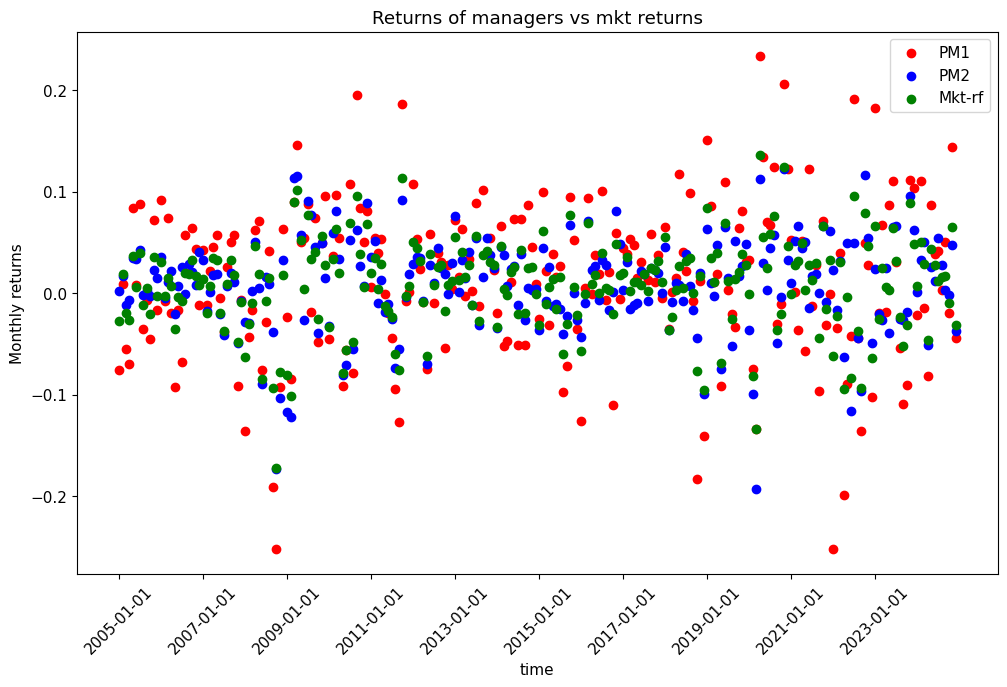

In [32]:
plt.scatter(y=df['PM1'], x=df.index,color='r', label='PM1')
plt.scatter(y=df['PM2'], x=df.index, color='b', label='PM2')
plt.scatter(y=df['Mkt-RF'], x=df.index, color='g', label='Mkt-rf')
plt.tight_layout()
plt.title('Returns of managers vs mkt returns')
plt.xlabel('time')
plt.ylabel('Monthly returns')
plt.xticks(ticks=df.index[::24], rotation=45)
plt.legend()
plt.show()






/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_36939/3874894647.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['PM1'], df['PM2']], labels=['PM1', 'PM2'])


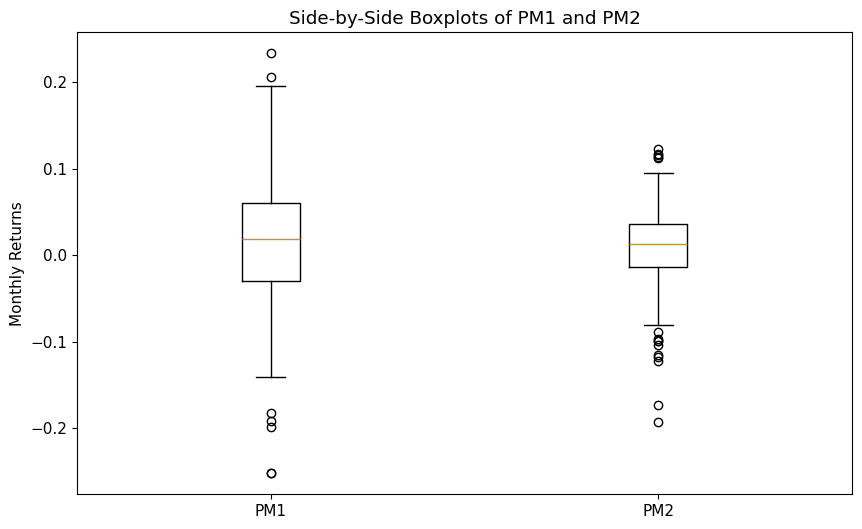

In [33]:
plt.figure(figsize=(10, 6))
plt.boxplot([df['PM1'], df['PM2']], labels=['PM1', 'PM2'])
plt.title('Side-by-Side Boxplots of PM1 and PM2')
plt.ylabel('Monthly Returns')
plt.show()

Differences between PM1 and PM2: 
1) Pm1 has much higher variance of returns than PM2. Both seem to have similar mean returns. PM2 also has many more outliers that PM1 particuarly in the negative direction.

There are several outliers for both series of plots for PM1 and PM2. PM2 has more outliers. 

In terms of outliers we may want to windzorise the data to remove high outliers and low ones too. 

In [34]:
df['PM1-RF'] = df['PM1']-df['RF']
df['PM2-RF'] = df['PM2']-df['RF']

df['PM1-MKT'] = df['PM1']-df['Mkt-RF']+df['RF']
df['PM2-MKT'] = df['PM2']-df['Mkt-RF']+df['RF']


In [35]:
def metrics(col):
    mu, sig = df[col].mean(), df[col].std()
    mu_xr = df[col+'-RF'].mean()
    var_xr = df[col+'-RF'].std() 

    SR = mu_xr/var_xr

    mu_xrm = df[col+'-MKT'].mean()
    var_xrm = df[col+'-MKT'].std()

    IR = mu_xrm/var_xrm
    
    returns = df[col].to_list()

    prod_returns = []
    cr = 1
    for i, r in enumerate(returns):
        cr*=(1+r)
        prod_returns.append(cr)


    n = len(returns)
    min_frm_rht = [prod_returns[n-1] for _ in range(n)]

    for i in range(1, n):
        min_frm_rht[n-1-i] = min(prod_returns[n-1-i],min_frm_rht[n-i])
    
    mx_drawdown = float('inf')

    for j, pr in enumerate(prod_returns):
        ddn = (min_frm_rht[j]-prod_returns[j])/prod_returns[j]
        mx_drawdown = min(ddn, mx_drawdown)

    mx_drawdown = 100*mx_drawdown

    print(f"STATS FOR {col}")
    print(f"Mean={mu:.4f} Std dev={sig:.4f}") 
    print(f"SR={SR:.4f} IR={IR:.4f}") 
    print(f"max drawdown={mx_drawdown:.4f} %") 
    print("X"*50)


metrics('PM1')
metrics('PM2')








STATS FOR PM1
Mean=0.0137 Std dev=0.0758
SR=0.1642 IR=0.1698
max drawdown=-59.2334 %
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
STATS FOR PM2
Mean=0.0087 Std dev=0.0466
SR=0.1584 IR=0.0958
max drawdown=-51.1975 %
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [36]:
#PM1 regression

Y = df['PM1-RF']
X = sm.add_constant(df[['Mkt-RF','HML','SMB']])

model_pm1 = sm.OLS(endog=Y, exog=X).fit()

model_pm1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM1-RF   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.361e+04
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          4.96e-264
Time:                        12:57:36   Log-Likelihood:                 898.10
No. Observations:                 240   AIC:                            -1788.
Df Residuals:                     236   BIC:                            -1774.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.249      0.213      -0.000       0.001
Mkt-RF         1.4137      0.009    157.805      0.000       1.396       1.431
HML           -0.8074      0.012    -68.223      0.000      -0.831      -0.784
SMB            0.9894      0.016     62.211      0.000       0.958       1.021
==============================================================================
Omnibus:                        5.807   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.486
Skew:                           0.335   Prob(JB):                       0.0644
Kurtosis:                       3.317   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
#PM2 regression

Y = df['PM2-RF']
X = sm.add_constant(df[['Mkt-RF','HML','SMB']])

model_pm2 = sm.OLS(endog=Y, exog=X).fit()

model_pm2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM2-RF   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2665.
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          1.16e-181
Time:                        12:57:37   Log-Likelihood:                 821.48
No. Observations:                 240   AIC:                            -1635.
Df Residuals:                     236   BIC:                            -1621.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.135      0.257      -0.000       0.002
Mkt-RF         0.9076      0.012     73.620      0.000       0.883       0.932
HML            0.5677      0.016     34.858      0.000       0.536       0.600
SMB           -0.1012      0.022     -4.623      0.000      -0.144      -0.058
==============================================================================
Omnibus:                        5.462   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.106
Skew:                           0.198   Prob(JB):                        0.128
Kurtosis:                       2.496   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Who's better at beating the market? Definitely PM1 higher information ratio. 
2. Who generates a better sharpe ratio? Definiely PM1 by a little. 
3. THe higher FF3 information ratio is also from PM1, which has a higher t-stat for the coeffecient 1.249 vs PM2's 1.135. 

In [38]:
# (c1) Which PM is better at beating the market? (CAPM alpha comparison)
# Formal test: stacked regression allowing different betas; HAC (Newey–West) SEs
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Excess returns and market factor
_y1 = df['PM1'] - df['RF']
_y2 = df['PM2'] - df['RF']
_Xf = df[['Mkt-RF']]

# Individual CAPM fits (HAC) for reference
_X1 = sm.add_constant(_Xf, has_constant='add')
_capm1 = sm.OLS(_y1, _X1).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_capm2 = sm.OLS(_y2, _X1).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_a1, _t1, _p1 = _capm1.params['const'], _capm1.tvalues['const'], _capm1.pvalues['const']
_a2, _t2, _p2 = _capm2.params['const'], _capm2.tvalues['const'], _capm2.pvalues['const']
print(f"PM1 CAPM alpha = {_a1:.6f} (t={_t1:.2f}, p={_p1:.3f}) | PM2 CAPM alpha = {_a2:.6f} (t={_t2:.2f}, p={_p2:.3f})")

# Stacked panel with PM2 dummy and interactions to allow different betas
_y = pd.concat([_y1, _y2], axis=0).reset_index(drop=True)
_Xrep = pd.concat([_Xf, _Xf], axis=0).reset_index(drop=True)
_D = np.r_[np.zeros(len(_y1)), np.ones(len(_y2))]

_X = _Xrep.copy()
_X['D'] = _D
_X['D*Mkt-RF'] = _D * _Xrep['Mkt-RF']
_X = sm.add_constant(_X, has_constant='add')

_capm_stack = sm.OLS(_y, _X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_gamma = _capm_stack.params['D']          # α2 − α1 under CAPM
_tg = _capm_stack.tvalues['D']
_pg = _capm_stack.pvalues['D']
print(f"Alpha difference (α2 − α1) = {_gamma:.6f} | t = {_tg:.2f} | p = {_pg:.3f}  [HAC, 12 lags]")

if _pg < 0.05:
    better = 'PM2' if _gamma > 0 else 'PM1'
    print(f"Conclusion (5%): Reject H0: α1 = α2. {better} is better at beating the market (higher CAPM alpha).")
else:
    print("Conclusion (5%): Fail to reject H0: α1 = α2. No statistically significant difference in market-beating ability.")


PM1 CAPM alpha = 0.000210 (t=0.08, p=0.938) | PM2 CAPM alpha = -0.000249 (t=-0.16, p=0.873)
Alpha difference (α2 − α1) = -0.000459 | t = -0.15 | p = 0.883  [HAC, 12 lags]
Conclusion (5%): Fail to reject H0: α1 = α2. No statistically significant difference in market-beating ability.


In [39]:
# (c2) Which can generate a higher Sharpe ratio? (Jobson–Korkie test)
import numpy as np

# Prepare returns and compute Sharpe ratios (excess over RF)
_returns = df[['PM1', 'PM2']].dropna()
_n = len(_returns)
_rho = _returns['PM1'].corr(_returns['PM2'])
_ex1 = _returns['PM1'] - df.loc[_returns.index, 'RF']
_ex2 = _returns['PM2'] - df.loc[_returns.index, 'RF']
_sr1 = _ex1.mean() / _ex1.std()
_sr2 = _ex2.mean() / _ex2.std()

# Jobson–Korkie statistic (1981)
def jobson_korkie(sr1, sr2, n, rho):
    var = (1.0 / n) * (2 * (1 - rho) + 0.5 * (sr1**2 + sr2**2 - 2 * rho * sr1 * sr2))
    return (sr1 - sr2) / np.sqrt(var)

_z = jobson_korkie(_sr1, _sr2, _n, _rho)
print(f"Sharpe PM1 = {_sr1:.4f} | Sharpe PM2 = {_sr2:.4f} | Z_JK = {_z:.2f}")

# Two-sided p-value under asymptotic normal
from scipy.stats import norm
_p_jk = 2 * (1 - norm.cdf(abs(_z)))
if _p_jk < 0.05:
    winner = 'PM1' if _sr1 > _sr2 else 'PM2'
    print(f"Conclusion (5%): Reject H0: Sharpe1 = Sharpe2. Higher Sharpe: {winner}.")
else:
    print("Conclusion (5%): Fail to reject H0: Sharpe1 = Sharpe2. No significant difference.")


Sharpe PM1 = 0.1642 | Sharpe PM2 = 0.1584 | Z_JK = 0.11
Conclusion (5%): Fail to reject H0: Sharpe1 = Sharpe2. No significant difference.


In [40]:
# (c3) Which can generate a higher information ratio (FF3-based)?
# IR_i = α_i / σ(ε_i) from FF3; inference via stacked regression test on α2 − α1
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Excess returns and FF3 factors
_y1 = df['PM1'] - df['RF']
_y2 = df['PM2'] - df['RF']
_Xf = df[['Mkt-RF', 'HML', 'SMB']]
_X1 = sm.add_constant(_Xf, has_constant='add')

# Individual FF3 fits
_ff3_1 = sm.OLS(_y1, _X1).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_ff3_2 = sm.OLS(_y2, _X1).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_alpha1, _alpha2 = _ff3_1.params['const'], _ff3_2.params['const']
_sigma_e1, _sigma_e2 = float(np.sqrt(_ff3_1.scale)), float(np.sqrt(_ff3_2.scale))
_ir1, _ir2 = _alpha1 / _sigma_e1, _alpha2 / _sigma_e2
print(f"FF3 IRs: IR1 = {_ir1:.4f} | IR2 = {_ir2:.4f} | ΔIR (PM2−PM1) = {_ir2 - _ir1:.4f}")

# Stacked FF3 regression to test α2 − α1
_y = pd.concat([_y1, _y2], axis=0).reset_index(drop=True)
_Xrep = pd.concat([_Xf, _Xf], axis=0).reset_index(drop=True)
_D = np.r_[np.zeros(len(_y1)), np.ones(len(_y2))]
_X = _Xrep.copy()
_X['D'] = _D
for _c in ['Mkt-RF', 'HML', 'SMB']:
    _X[f'D*{_c}'] = _D * _Xrep[_c]
_X = sm.add_constant(_X, has_constant='add')

_ff3_stack = sm.OLS(_y, _X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
_gamma = _ff3_stack.params['D']
_tg = _ff3_stack.tvalues['D']
_pg = _ff3_stack.pvalues['D']
print(f"Alpha difference (α2 − α1) = {_gamma:.6f} | t = {_tg:.2f} | p = {_pg:.3f}  [HAC, 12 lags]")

if _pg < 0.05:
    better = 'PM2' if _gamma > 0 else 'PM1'
    print(f"Conclusion (5%): Reject H0: α1 = α2. {better} has higher risk-adjusted alpha (IR).")
else:
    print("Conclusion (5%): Fail to reject H0: α1 = α2. IRs differ economically but not statistically via α.")


FF3 IRs: IR1 = 0.0822 | IR2 = 0.0748 | ΔIR (PM2−PM1) = -0.0075
Alpha difference (α2 − α1) = 0.000119 | t = 0.20 | p = 0.842  [HAC, 12 lags]
Conclusion (5%): Fail to reject H0: α1 = α2. IRs differ economically but not statistically via α.
